<a href="https://colab.research.google.com/github/MaheenGitHub/IS_Project/blob/main/full_fledge_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Colab setup & imports
import sys
print("Python", sys.version)

# check GPU
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

# Basic imports
import os
import random
import numpy as np
from pathlib import Path


Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch version: 2.8.0+cu126
CUDA available: True
Device: Tesla T4


In [2]:
# @title Set seed for reproducibility
def set_seed(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)
print("Seed set")


Seed set


In [4]:
# @title (Optional) Ensure torchvision is installed - run as a shell cell if needed
# If you already have torchvision compatible with torch, skip this cell.
# In Colab, this usually isn't necessary.
!pip install -q torchvision


In [5]:
# @title Data loaders (CIFAR-10) with augmentation
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

DATA_DIR = './data_cifar10'

transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transform_test)

BATCH_SIZE = 128  # you can reduce if GPU memory is low
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(trainset), "Test size:", len(testset))


100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s]


Train size: 50000 Test size: 10000


In [6]:
# @title Model, optimizer, loss, train & validate functions
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model(num_classes=10, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    # Change final layer
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model.to(device)

model = get_model(num_classes=10, pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60], gamma=0.1)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc="Train", leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)
    return running_loss/total, 100.*correct/total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validate", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss/total, 100.*correct/total


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 92.4MB/s]


In [7]:
# @title Train the model (run this cell; change EPOCHS if you want)
EPOCHS = 5  # start with 5 epochs to get baseline quickly; we will extend later if needed
best_acc = 0.0
save_path = "resnet18_cifar10.pth"

for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}/{EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()
    print(f"Train loss: {train_loss:.4f}  Train acc: {train_acc:.2f}%")
    print(f"Val   loss: {val_loss:.4f}  Val   acc: {val_acc:.2f}%")
    # save best
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, save_path)
        print("Saved checkpoint:", save_path)

print("Training finished. Best val acc:", best_acc)


Epoch 1/5


Train loss: 1.0420  Train acc: 64.04%
Val   loss: 0.7790  Val   acc: 73.60%
Saved checkpoint: resnet18_cifar10.pth
Epoch 2/5


Train loss: 0.7057  Train acc: 75.98%
Val   loss: 0.6484  Val   acc: 78.13%
Saved checkpoint: resnet18_cifar10.pth
Epoch 3/5


Train loss: 0.6151  Train acc: 78.94%
Val   loss: 0.6085  Val   acc: 79.47%
Saved checkpoint: resnet18_cifar10.pth
Epoch 4/5


Train loss: 0.5681  Train acc: 80.53%
Val   loss: 0.5535  Val   acc: 81.49%
Saved checkpoint: resnet18_cifar10.pth
Epoch 5/5


Train loss: 0.5202  Train acc: 81.83%
Val   loss: 0.5628  Val   acc: 80.54%
Training finished. Best val acc: 81.49


In [8]:
# @title Attack utilities & visualization helpers
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# For displaying images (undo the CIFAR-10 normalization)
mean = np.array([0.4914, 0.4822, 0.4465])
std  = np.array([0.2023, 0.1994, 0.2010])

def unnormalize(img_tensor):
    # img_tensor: CPU tensor [C,H,W] in normalized form
    img = img_tensor.clone().cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

def show_images(imgs, titles=None, figsize=(12,4), cols=6):
    # imgs: list of tensors [C,H,W] or numpy arrays HxWxC
    n = len(imgs)
    cols = min(cols, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        if isinstance(im, torch.Tensor):
            im = unnormalize(im)
        plt.imshow(im)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i], fontsize=9)
    plt.tight_layout()
    plt.show()


In [9]:
# @title Load trained model checkpoint
import torch
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(path="resnet18_cifar10.pth"):
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    print("Loaded checkpoint from epoch", checkpoint.get('epoch', '?'), "val_acc:", checkpoint.get('val_acc', '?'))
    return model

model = load_model("resnet18_cifar10.pth")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded checkpoint from epoch 4 val_acc: 81.49


In [10]:
# @title FGSM and PGD attack functions (white-box)
import torch

def fgsm_attack(model, images, labels, eps=0.03):
    """
    images: tensor [B,C,H,W] normalized
    labels: tensor [B]
    eps: float (in normalized pixel scale; for CIFAR typical values 0.01-0.08)
    returns adversarial images (clipped to valid range after un-normalizing)
    """
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    grad = images.grad.data

    adv_images = images + eps * grad.sign()
    # Because inputs are normalized, we must keep them in the normalized domain but clip so that
    # after unnormalization pixel values remain in [0,1]. An easy practical approach:
    # convert back to unnormalized, clamp, re-normalize.
    adv_unnorm = adv_images.clone().detach().cpu()
    # convert to unnormalized: x_unnorm = x_norm * std + mean
    for c in range(3):
        adv_unnorm[:, c, :, :] = adv_unnorm[:, c, :, :]*std[c] + mean[c]
    adv_unnorm = torch.clamp(adv_unnorm, 0.0, 1.0)
    # re-normalize
    for c in range(3):
        adv_unnorm[:, c, :, :] = (adv_unnorm[:, c, :, :] - mean[c]) / std[c]
    adv_images = adv_unnorm.to(device)
    return adv_images.detach()

def pgd_attack(model, images, labels, eps=0.03, alpha=0.007, iters=10):
    """
    Projected Gradient Descent (L_inf)
    eps: max perturbation (in normalized range converted via std/mean approach below)
    alpha: step size per iteration
    iters: number of iterations
    """
    ori_images = images.clone().detach().to(device)
    images = ori_images.clone().detach().to(device)
    labels = labels.to(device)

    # random start
    # Uniform noise in [-eps, eps] in unnormalized domain then renorm
    rand = torch.empty_like(images).uniform_(-eps, eps)
    images = images + rand
    # Ensure valid after clipping as in FGSM
    for c in range(3):
        tmp = images[:, c, :, :].clone()
        tmp = tmp*std[c] + mean[c]
        tmp = torch.clamp(tmp, 0.0, 1.0)
        images[:, c, :, :] = (tmp - mean[c]) / std[c]

    images.requires_grad = True

    for i in range(iters):
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = images.grad.data

        images = images + alpha * grad.sign()
        # Project back to epsilon ball around original images (in unnormalized pixel domain)
        # convert to unnorm, clamp, then project
        unnorm = images.clone().detach()
        ori_unnorm = ori_images.clone().detach()
        for c in range(3):
            unnorm[:, c, :, :] = unnorm[:, c, :, :]*std[c] + mean[c]
            ori_unnorm[:, c, :, :] = ori_unnorm[:, c, :, :]*std[c] + mean[c]

        # clip to [ori - eps, ori + eps] in unnormalized domain
        upper = torch.clamp(ori_unnorm + eps, 0.0, 1.0)
        lower = torch.clamp(ori_unnorm - eps, 0.0, 1.0)
        unnorm = torch.max(torch.min(unnorm, upper), lower)

        # clamp to valid pixel range
        unnorm = torch.clamp(unnorm, 0.0, 1.0)
        # re-normalize
        for c in range(3):
            unnorm[:, c, :, :] = (unnorm[:, c, :, :] - mean[c]) / std[c]

        images = unnorm.clone().detach()
        images.requires_grad = True

    return images.detach()


Attack Eval: 100%|██████████| 79/79 [00:05<00:00, 13.98it/s]


Test accuracy under FGSM (eps=0.03): 44.58%


Attack Eval: 100%|██████████| 79/79 [00:39<00:00,  2.00it/s]

Test accuracy under PGD (eps=0.03, iters=10): 7.44%


Showing original (top), FGSM (middle), PGD (bottom) — labels show predicted class indices.


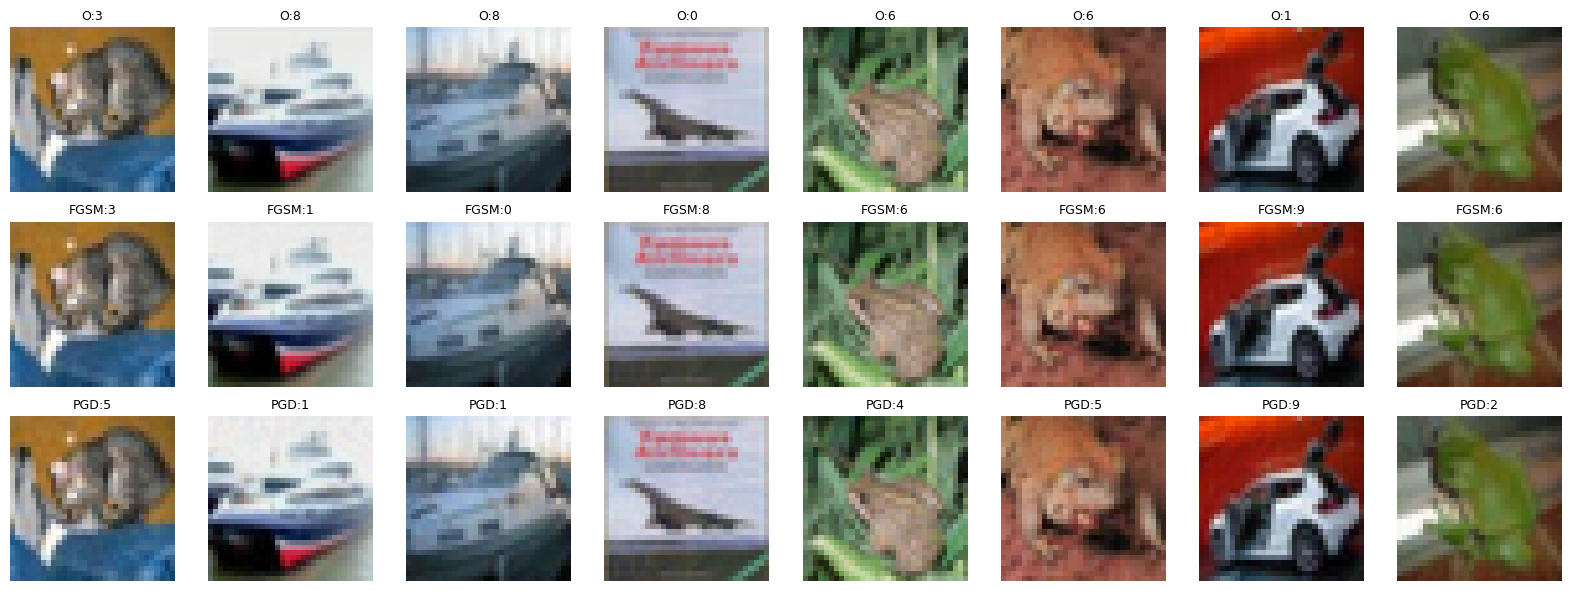

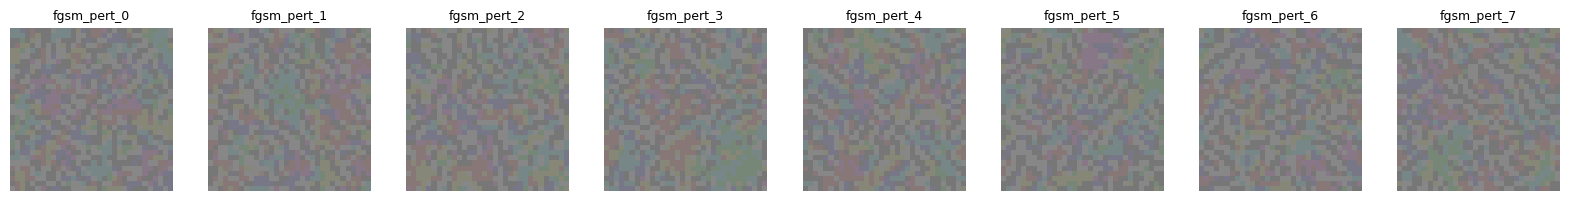

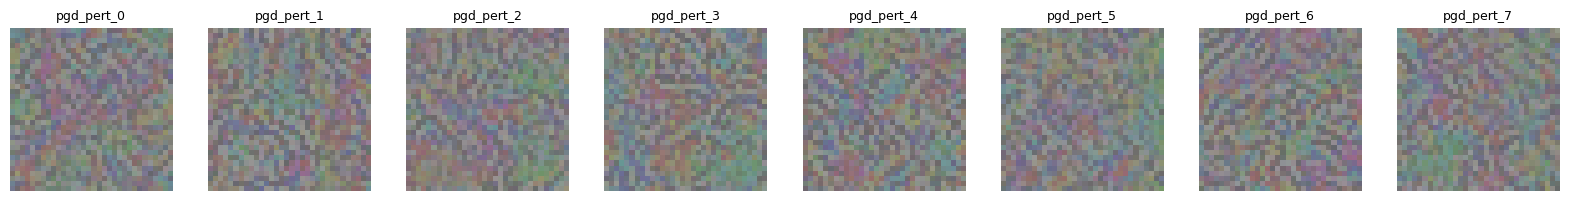

In [11]:
# @title Evaluate attacks on test set (run; will print attacked accuracies)
import torch
from tqdm import tqdm

def evaluate_under_attack(model, loader, attack_fn, attack_kwargs, device):
    model.eval()
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Attack Eval"):
        images, labels = images.to(device), labels.to(device)
        adv_images = attack_fn(model, images, labels, **attack_kwargs)
        with torch.no_grad():
            outputs = model(adv_images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return 100. * correct / total

# Try FGSM with eps=0.03
eps_fgsm = 0.03
acc_fgsm = evaluate_under_attack(model, test_loader, fgsm_attack, {'eps': eps_fgsm}, device)
print(f"Test accuracy under FGSM (eps={eps_fgsm}): {acc_fgsm:.2f}%")

# Try PGD with eps=0.03, alpha=0.007, iters=10
eps_pgd = 0.03
acc_pgd = evaluate_under_attack(model, test_loader, pgd_attack, {'eps': eps_pgd, 'alpha': 0.007, 'iters': 10}, device)
print(f"Test accuracy under PGD (eps={eps_pgd}, iters=10): {acc_pgd:.2f}%")

# Visualize some examples from test set (first batch): orig, adv (FGSM), perturbation
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images[:8].to(device)
labels = labels[:8].to(device)

adv_fgsm_batch = fgsm_attack(model, images, labels, eps=eps_fgsm)
adv_pgd_batch = pgd_attack(model, images, labels, eps=eps_pgd, alpha=0.007, iters=10)

# predictions
with torch.no_grad():
    orig_preds = model(images).argmax(dim=1).cpu().numpy()
    fgsm_preds = model(adv_fgsm_batch).argmax(dim=1).cpu().numpy()
    pgd_preds  = model(adv_pgd_batch).argmax(dim=1).cpu().numpy()

# prepare images for display (unnormalize inside helper)
imgs_to_show = []
titles = []
for i in range(images.size(0)):
    imgs_to_show.append(images[i].cpu())
    titles.append(f"O:{orig_preds[i]}")
for i in range(adv_fgsm_batch.size(0)):
    imgs_to_show.append(adv_fgsm_batch[i].cpu())
    titles.append(f"FGSM:{fgsm_preds[i]}")
for i in range(adv_pgd_batch.size(0)):
    imgs_to_show.append(adv_pgd_batch[i].cpu())
    titles.append(f"PGD:{pgd_preds[i]}")

print("Showing original (top), FGSM (middle), PGD (bottom) — labels show predicted class indices.")
show_images(imgs_to_show, titles=titles, cols=8, figsize=(16,6))

# Also show the perturbations (unnormalized pixel difference) for first 8
perturb_fgsm = adv_fgsm_batch.cpu() - images.cpu()
perturb_pgd  = adv_pgd_batch.cpu() - images.cpu()
# convert to pixel-space for visualization
def perturb_to_image(pert):
    p = pert.clone().numpy()
    p = np.transpose(p, (0,2,3,1))
    # scale for visibility (multiply by 3 or 5)
    p_vis = p * 5.0
    # convert normalized delta to pixel delta via std
    for c in range(3):
        p_vis[..., c] = p_vis[..., c] * std[c]
    p_vis = np.clip((p_vis + 0.5), 0, 1)  # shift for display
    return [p_vis[i] for i in range(p_vis.shape[0])]

show_images(perturb_to_image(perturb_fgsm), titles=[f"fgsm_pert_{i}" for i in range(perturb_fgsm.size(0))], cols=8, figsize=(16,2))
show_images(perturb_to_image(perturb_pgd), titles=[f"pgd_pert_{i}" for i in range(perturb_pgd.size(0))], cols=8, figsize=(16,2))


In [12]:
# @title PGD attack function for adversarial training (on-the-fly)
import torch

def pgd_attack_for_train(model, images, labels, eps=8/255.0, alpha=2/255.0, iters=10, random_start=True):
    """
    Generate adversarial examples (L_inf PGD) for adversarial training.
    images, labels: normalized tensors on device
    eps, alpha: in pixel-space [0,1] units (we will handle normalization)
    iters: PGD steps
    """
    model.eval()  # don't update batchnorm stats while crafting
    ori_images = images.clone().detach()
    x = ori_images.clone().detach()

    if random_start:
        # uniform noise in [-eps, eps] in pixel space then normalize
        rand = torch.empty_like(x).uniform_(-eps, eps).to(x.device)
        # Apply in normalized space:
        for c in range(3):
            x[:, c, :, :] = x[:, c, :, :] + rand[:, c, :, :]/std[c]
        # Clip to valid pixel range via unnormalize -> clamp -> renorm
        for c in range(3):
            tmp = x[:, c, :, :].clone()
            tmp = tmp*std[c] + mean[c]
            tmp = torch.clamp(tmp, 0.0, 1.0)
            x[:, c, :, :] = (tmp - mean[c]) / std[c]

    x.requires_grad = True
    for i in range(iters):
        outputs = model(x)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        model.zero_grad()
        if x.grad is not None:
            x.grad.zero_()
        loss.backward()
        grad = x.grad.data
        x = x + (alpha) * grad.sign()
        # project to epsilon ball around ori_images in pixel domain
        unnorm = x.clone().detach()
        ori_unnorm = ori_images.clone().detach()
        for c in range(3):
            unnorm[:, c, :, :] = unnorm[:, c, :, :]*std[c] + mean[c]
            ori_unnorm[:, c, :, :] = ori_unnorm[:, c, :, :]*std[c] + mean[c]
        upper = torch.clamp(ori_unnorm + eps, 0.0, 1.0)
        lower = torch.clamp(ori_unnorm - eps, 0.0, 1.0)
        unnorm = torch.max(torch.min(unnorm, upper), lower)
        unnorm = torch.clamp(unnorm, 0.0, 1.0)
        # re-normalize
        for c in range(3):
            unnorm[:, c, :, :] = (unnorm[:, c, :, :] - mean[c]) / std[c]
        x = unnorm.clone().detach()
        x.requires_grad = True

    model.train()
    return x.detach()


In [13]:
# @title Adversarial training (PGD-based) function and helpers
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

def adversarial_train(model, train_loader, test_loader, epochs=30, eps=8/255.0, alpha=2/255.0, pgd_iters=10,
                      lr=0.1, batch_size=128, save_path="robust_resnet18_cifar10.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scaler = GradScaler()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)  # can adjust for long runs
    criterion = torch.nn.CrossEntropyLoss()
    best_clean = 0.0
    best_robust = 0.0

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f"AdvTrain Epoch {epoch}/{epochs}", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            # craft adversarial examples on-the-fly
            adv_images = pgd_attack_for_train(model, images, labels, eps=eps, alpha=alpha, iters=pgd_iters, random_start=True)

            optimizer.zero_grad()
            # use mixed precision to speed up and save memory
            with autocast():
                outputs = model(adv_images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({'loss': running_loss/total, 'acc': 100.*correct/total})

        # scheduler step (optional)
        scheduler.step()

        # Evaluate clean & robust accuracy after each epoch
        clean_loss, clean_acc = validate(model, test_loader, criterion, device)
        robust_acc = evaluate_under_attack(model, test_loader, pgd_attack, {'eps': eps, 'alpha': alpha, 'iters': pgd_iters}, device)

        print(f"Epoch {epoch}: Train acc (adv-train): {100.*correct/total:.2f}%  Clean Acc: {clean_acc:.2f}%  Robust Acc (PGD): {robust_acc:.2f}%")

        # save best models separately by robust accuracy and by clean accuracy
        if robust_acc > best_robust:
            best_robust = robust_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'clean_acc': clean_acc,
                'robust_acc': robust_acc
            }, save_path)
            print("Saved robust checkpoint:", save_path)
        # optional: also save best clean
        if clean_acc > best_clean:
            best_clean = clean_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'clean_acc': clean_acc,
                'robust_acc': robust_acc
            }, "best_clean_"+save_path)
    return model, best_clean, best_robust


In [14]:
# @title Prepare model and run adversarial training (run this cell to start)
# Note: you already have a pretrained model variable 'model' from earlier; we'll use that weights as init
# If you want to start from scratch, reinitialize get_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=10, pretrained=False)  # start from ImageNet-pretrained backbone? set pretrained=True if you want
# If you want to initialize from the checkpoint you trained earlier (clean model), load it:
ck = torch.load("resnet18_cifar10.pth", map_location=device)
model.load_state_dict(ck['model_state_dict'])
model = model.to(device)

# Training hyperparameters — you can tune these
EPOCHS = 30          # strong setting
PGD_ITERS = 10       # Madry-style
EPS = 8/255.0        # maximum perturbation in pixel space
ALPHA = 2/255.0      # step size
LR = 0.1

# Run adversarial training
model, best_clean, best_robust = adversarial_train(model, train_loader, test_loader,
                                                   epochs=EPOCHS, eps=EPS, alpha=ALPHA,
                                                   pgd_iters=PGD_ITERS, lr=LR,
                                                   batch_size=BATCH_SIZE,
                                                   save_path="robust_resnet18_cifar10.pth")

print("Adversarial training finished. Best clean acc:", best_clean, " Best robust acc:", best_robust)


/tmp/ipython-input-3595292889.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
AdvTrain Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-3595292889.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 1: Train acc (adv-train): 24.19%  Clean Acc: 39.67%  Robust Acc (PGD): 29.16%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 2: Train acc (adv-train): 32.08%  Clean Acc: 44.08%  Robust Acc (PGD): 30.26%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 3: Train acc (adv-train): 35.88%  Clean Acc: 50.56%  Robust Acc (PGD): 34.08%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 4: Train acc (adv-train): 39.08%  Clean Acc: 55.81%  Robust Acc (PGD): 37.50%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 5: Train acc (adv-train): 40.89%  Clean Acc: 55.44%  Robust Acc (PGD): 37.49%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 6: Train acc (adv-train): 41.82%  Clean Acc: 53.12%  Robust Acc (PGD): 35.88%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 7: Train acc (adv-train): 42.48%  Clean Acc: 61.42%  Robust Acc (PGD): 42.44%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 8: Train acc (adv-train): 44.24%  Clean Acc: 60.65%  Robust Acc (PGD): 41.88%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 9: Train acc (adv-train): 45.04%  Clean Acc: 64.67%  Robust Acc (PGD): 44.50%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 10: Train acc (adv-train): 46.02%  Clean Acc: 63.29%  Robust Acc (PGD): 42.47%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 11: Train acc (adv-train): 46.65%  Clean Acc: 65.00%  Robust Acc (PGD): 43.00%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 12: Train acc (adv-train): 47.19%  Clean Acc: 64.11%  Robust Acc (PGD): 43.29%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 13: Train acc (adv-train): 47.90%  Clean Acc: 64.41%  Robust Acc (PGD): 42.90%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 14: Train acc (adv-train): 48.13%  Clean Acc: 66.17%  Robust Acc (PGD): 43.34%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 15: Train acc (adv-train): 48.38%  Clean Acc: 67.19%  Robust Acc (PGD): 45.51%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 16: Train acc (adv-train): 48.52%  Clean Acc: 67.73%  Robust Acc (PGD): 46.70%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 17: Train acc (adv-train): 49.38%  Clean Acc: 65.39%  Robust Acc (PGD): 43.45%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 18: Train acc (adv-train): 49.17%  Clean Acc: 67.57%  Robust Acc (PGD): 44.93%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 19: Train acc (adv-train): 49.57%  Clean Acc: 66.08%  Robust Acc (PGD): 44.80%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 20: Train acc (adv-train): 49.75%  Clean Acc: 69.59%  Robust Acc (PGD): 47.07%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 21: Train acc (adv-train): 49.92%  Clean Acc: 66.21%  Robust Acc (PGD): 44.28%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 22: Train acc (adv-train): 49.98%  Clean Acc: 64.49%  Robust Acc (PGD): 42.54%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 23: Train acc (adv-train): 49.93%  Clean Acc: 69.04%  Robust Acc (PGD): 47.93%
Saved robust checkpoint: robust_resnet18_cifar10.pth


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 24: Train acc (adv-train): 50.47%  Clean Acc: 69.00%  Robust Acc (PGD): 46.08%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 25: Train acc (adv-train): 50.38%  Clean Acc: 67.82%  Robust Acc (PGD): 45.11%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 26: Train acc (adv-train): 50.51%  Clean Acc: 68.99%  Robust Acc (PGD): 45.91%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 27: Train acc (adv-train): 50.69%  Clean Acc: 67.08%  Robust Acc (PGD): 46.67%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 28: Train acc (adv-train): 51.00%  Clean Acc: 69.17%  Robust Acc (PGD): 46.68%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 29: Train acc (adv-train): 50.93%  Clean Acc: 68.00%  Robust Acc (PGD): 46.03%


Attack Eval: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]

Epoch 30: Train acc (adv-train): 51.27%  Clean Acc: 69.05%  Robust Acc (PGD): 46.29%
Adversarial training finished. Best clean acc: 69.59  Best robust acc: 47.93


In [15]:
# @title Save Robust Model Checkpoint to Google Drive
import shutil
import os

# Define the target path in your Google Drive
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/AI_Security_Red_Team_Toolkit/Checkpoints'
LOCAL_SAVE_PATH = 'robust_resnet18_cifar10.pth'

# 1. Create the directory if it doesn't exist
os.makedirs(DRIVE_PROJECT_PATH, exist_ok=True)

# 2. Define the final path for the saved file
final_drive_path = os.path.join(DRIVE_PROJECT_PATH, LOCAL_SAVE_PATH)

# 3. Copy the file from local Colab storage to Google Drive
if os.path.exists(LOCAL_SAVE_PATH):
    shutil.copyfile(LOCAL_SAVE_PATH, final_drive_path)
    print(f"✅ Successfully saved {LOCAL_SAVE_PATH} to:")
    print(final_drive_path)
else:
    print(f"❌ Error: Model checkpoint {LOCAL_SAVE_PATH} not found locally.")

✅ Successfully saved robust_resnet18_cifar10.pth to:
/content/drive/MyDrive/AI_Security_Red_Team_Toolkit/Checkpoints/robust_resnet18_cifar10.pth


In [16]:
# @title Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted at /content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted at /content/drive


In [18]:
# @title Re-Copy All Local Files and Folders to Drive
import os

# Define the target backup folder name in your Google Drive
BACKUP_FOLDER_NAME = 'My_AI_Security_Project_Backup_18Nov'
DRIVE_PATH = f'/content/drive/MyDrive/{BACKUP_FOLDER_NAME}'

# Create the backup directory if it doesn't exist
os.makedirs(DRIVE_PATH, exist_ok=True)

print(f"Starting robust copy process to: {DRIVE_PATH}")

# Use a shell loop to iterate over all files and directories, excluding the Drive mount itself
# This avoids the 'unrecognized option' error.
!for file in *; do if [ "$file" != "drive" ]; then cp -r "$file" "{DRIVE_PATH}"; fi; done

print("\n✅ Robust copy complete! Please check your Google Drive folder now.")

Starting robust copy process to: /content/drive/MyDrive/My_AI_Security_Project_Backup_18Nov
cp: cannot overwrite non-directory '{DRIVE_PATH}' with directory 'data_cifar10'
cp: cannot overwrite non-directory '{DRIVE_PATH}' with directory 'sample_data'

✅ Robust copy complete! Please check your Google Drive folder now.


In [19]:
# @title Load robust model & helpers for evaluation
import torch
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

robust_ck_path = "robust_resnet18_cifar10.pth"
ck = torch.load(robust_ck_path, map_location=device)
robust_model = models.resnet18(pretrained=False)
robust_model.fc = torch.nn.Linear(robust_model.fc.in_features, 10)
robust_model.load_state_dict(ck['model_state_dict'])
robust_model = robust_model.to(device)
robust_model.eval()
print("Loaded robust checkpoint epoch:", ck.get('epoch', '?'), "clean_acc:", ck.get('clean_acc', '?'), "robust_acc:", ck.get('robust_acc', '?'))

# class names for CIFAR-10
cifar10_classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


Loaded robust checkpoint epoch: 23 clean_acc: 69.04 robust_acc: 47.93


In [20]:
# @title Per-class accuracy + confusion matrices (clean & PGD adversarial)
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm

def eval_and_confusion(model, loader, attack_fn=None, attack_kwargs=None):
    model.eval()
    y_true = []
    y_pred = []
    for images, labels in tqdm(loader, desc="Eval Loop"):
        images, labels = images.to(device), labels.to(device)
        if attack_fn is not None:
            images = attack_fn(model, images, labels, **(attack_kwargs or {}))
        with torch.no_grad():
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

# Clean evaluation
y_true_clean, y_pred_clean = eval_and_confusion(robust_model, test_loader, attack_fn=None)
cm_clean = confusion_matrix(y_true_clean, y_pred_clean, labels=list(range(10)))

# Robust evaluation (PGD)
pgd_eval_kwargs = {'eps': 8/255.0, 'alpha': 2/255.0, 'iters': 10}
y_true_adv, y_pred_adv = eval_and_confusion(robust_model, test_loader, attack_fn=pgd_attack, attack_kwargs=pgd_eval_kwargs)
cm_adv = confusion_matrix(y_true_adv, y_pred_adv, labels=list(range(10)))

# Per-class accuracies
per_class_clean = np.diag(cm_clean) / cm_clean.sum(axis=1)
per_class_robust = np.diag(cm_adv) / cm_adv.sum(axis=1)

df = pd.DataFrame({
    'class_idx': list(range(10)),
    'class_name': cifar10_classes,
    'clean_correct': np.diag(cm_clean),
    'clean_total': cm_clean.sum(axis=1),
    'clean_acc': (per_class_clean*100).round(2),
    'robust_correct': np.diag(cm_adv),
    'robust_total': cm_adv.sum(axis=1),
    'robust_acc': (per_class_robust*100).round(2),
    'attack_success_rate_%': (100*((1-per_class_robust))).round(2)
})

print("Overall clean acc: {:.2f}%".format(100.*np.sum(np.diag(cm_clean))/np.sum(cm_clean)))
print("Overall robust acc (PGD): {:.2f}%".format(100.*np.sum(np.diag(cm_adv))/np.sum(cm_adv)))
display(df)

# Save CSV
csv_path = "robust_evaluation_per_class.csv"
df.to_csv(csv_path, index=False)
print("Saved per-class report to:", csv_path)


Eval Loop: 100%|██████████| 79/79 [00:39<00:00,  2.00it/s]

Overall clean acc: 69.04%
Overall robust acc (PGD): 47.91%


,class_idx,class_name,clean_correct,clean_total,clean_acc,robust_correct,robust_total,robust_acc,attack_success_rate_%
0,0,airplane,718,1000,71.8,546,1000,54.6,45.4
1,1,automobile,892,1000,89.2,694,1000,69.4,30.6
2,2,bird,463,1000,46.3,242,1000,24.2,75.8
3,3,cat,391,1000,39.1,187,1000,18.7,81.3
4,4,deer,670,1000,67.0,364,1000,36.4,63.6
5,5,dog,669,1000,66.9,472,1000,47.2,52.8
6,6,frog,853,1000,85.3,649,1000,64.9,35.1
7,7,horse,588,1000,58.8,374,1000,37.4,62.6
8,8,ship,907,1000,90.7,758,1000,75.8,24.2
9,9,truck,753,1000,75.3,505,1000,50.5,49.5


Saved per-class report to: robust_evaluation_per_class.csv


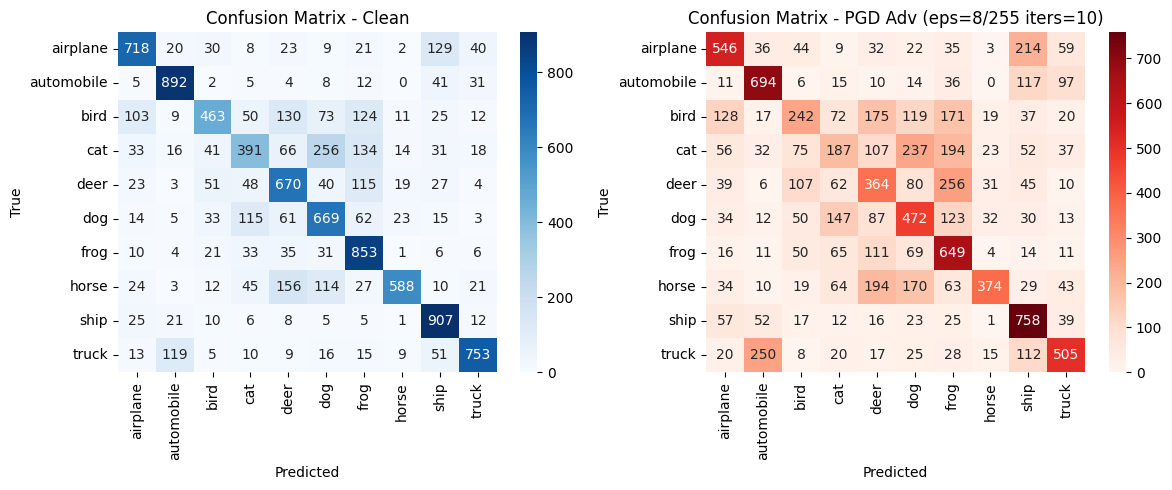

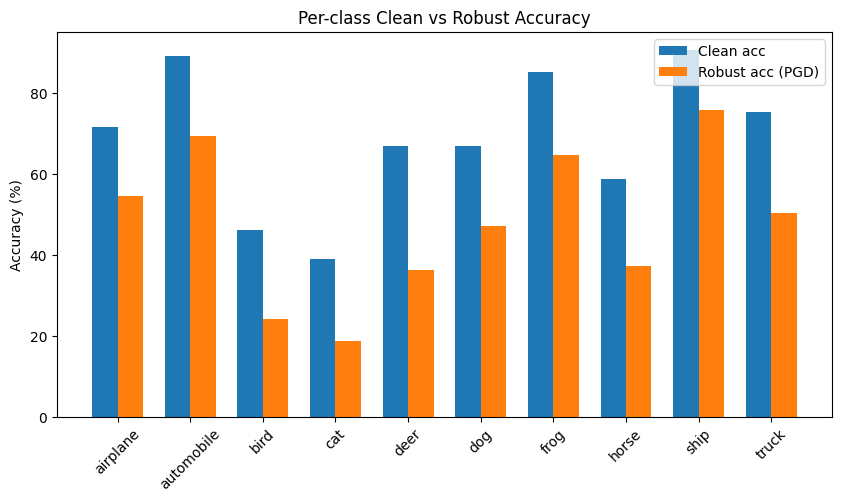

In [21]:
# @title Plot confusion matrices and per-class bar chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title('Confusion Matrix - Clean')
plt.xlabel('Predicted'); plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Reds', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title('Confusion Matrix - PGD Adv (eps=8/255 iters=10)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

# Bar chart for per-class robust acc vs clean acc
x = np.arange(len(cifar10_classes))
width = 0.35
plt.figure(figsize=(10,5))
plt.bar(x - width/2, df['clean_acc'], width, label='Clean acc')
plt.bar(x + width/2, df['robust_acc'], width, label='Robust acc (PGD)')
plt.xticks(x, cifar10_classes, rotation=45)
plt.ylabel('Accuracy (%)')
plt.title('Per-class Clean vs Robust Accuracy')
plt.legend()
plt.show()


In [22]:
# @title Save one misclassified adversarial example per true class (for report)
import os
os.makedirs("adv_examples_per_class", exist_ok=True)
from PIL import Image

# We'll iterate through test_loader batches and pick first misclassified PGD example for each class
found = {i: False for i in range(10)}
saved = 0
dataiter = iter(test_loader)
while not all(found.values()):
    try:
        images, labels = next(dataiter)
    except StopIteration:
        break
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(robust_model, images, labels, eps=8/255.0, alpha=2/255.0, iters=10)
    with torch.no_grad():
        preds = robust_model(adv_images).argmax(dim=1).cpu().numpy()
    images_cpu = images.cpu()
    adv_cpu = adv_images.cpu()
    labels_np = labels.cpu().numpy()
    for i in range(images_cpu.size(0)):
        true = int(labels_np[i])
        pred = int(preds[i])
        if not found[true] and pred != true:
            # save original, adv, and perturbation
            orig_img = unnormalize(images_cpu[i])
            adv_img = unnormalize(adv_cpu[i])
            pert = adv_cpu[i] - images_cpu[i]
            pert_vis = (np.transpose(pert.numpy(), (1,2,0)) * std) * 5.0 + 0.5
            pert_vis = np.clip(pert_vis, 0, 1)

            # Save images (as PNG)
            Image.fromarray((orig_img*255).astype('uint8')).save(f"adv_examples_per_class/{true}_orig.png")
            Image.fromarray((adv_img*255).astype('uint8')).save(f"adv_examples_per_class/{true}_adv.png")
            Image.fromarray((pert_vis*255).astype('uint8')).save(f"adv_examples_per_class/{true}_pert.png")

            found[true] = True
            saved += 1
    if saved >= 10:
        break

print("Saved adversarial failure examples to adv_examples_per_class/ (orig/adv/pert for each class if found)")


Saved adversarial failure examples to adv_examples_per_class/ (orig/adv/pert for each class if found)


In [24]:
!pip install --upgrade requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchattacks 3.5.1 requires requests~=2.25.1, but you have requests 2.32.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [28]:
!cp -av /content/* "/content/drive/MyDrive/Colab Notebooks/"


'/content/adv_examples_per_class' -> '/content/drive/MyDrive/Colab Notebooks/adv_examples_per_class'
'/content/adv_examples_per_class/3_orig.png' -> '/content/drive/MyDrive/Colab Notebooks/adv_examples_per_class/3_orig.png'
'/content/adv_examples_per_class/3_adv.png' -> '/content/drive/MyDrive/Colab Notebooks/adv_examples_per_class/3_adv.png'
'/content/adv_examples_per_class/3_pert.png' -> '/content/drive/MyDrive/Colab Notebooks/adv_examples_per_class/3_pert.png'
'/content/adv_examples_per_class/0_orig.png' -> '/content/drive/MyDrive/Colab Notebooks/adv_examples_per_class/0_orig.png'
'/content/adv_examples_per_class/0_adv.png' -> '/content/drive/MyDrive/Colab Notebooks/adv_examples_per_class/0_adv.png'
'/content/adv_examples_per_class/0_pert.png' -> '/content/drive/MyDrive/Colab Notebooks/adv_examples_per_class/0_pert.png'
'/content/adv_examples_per_class/1_orig.png' -> '/content/drive/MyDrive/Colab Notebooks/adv_examples_per_class/1_orig.png'
'/content/adv_examples_per_class/1_adv.png

In [29]:
# @title Carlini-Wagner (C&W L2) Attack Evaluation
!pip install torchattacks -q  # install if not already

import torchattacks
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize C&W L2 attack
cw_attack = torchattacks.CW(robust_model, c=1e-4, kappa=0, steps=1000, lr=0.01)

# Evaluate C&W attack
y_true_cw = []
y_pred_cw = []

for images, labels in tqdm(test_loader, desc="C&W Eval Loop"):
    images, labels = images.to(device), labels.to(device)
    adv_images = cw_attack(images, labels)
    with torch.no_grad():
        outputs = robust_model(adv_images)
        preds = outputs.argmax(dim=1).cpu().numpy()
    y_true_cw.extend(labels.cpu().numpy())
    y_pred_cw.extend(preds)

y_true_cw = np.array(y_true_cw)
y_pred_cw = np.array(y_pred_cw)

# Confusion matrix & overall accuracy
cm_cw = confusion_matrix(y_true_cw, y_pred_cw, labels=list(range(10)))
overall_robust_cw = 100.*np.sum(np.diag(cm_cw))/np.sum(cm_cw)

print(f"Overall robust accuracy under C&W L2 attack: {overall_robust_cw:.2f}%")

# Per-class accuracy
per_class_robust_cw = np.diag(cm_cw) / cm_cw.sum(axis=1)
df_cw = pd.DataFrame({
    'class_idx': list(range(10)),
    'class_name': cifar10_classes,
    'robust_correct_CW': np.diag(cm_cw),
    'robust_total_CW': cm_cw.sum(axis=1),
    'robust_acc_CW': (per_class_robust_cw*100).round(2),
    'attack_success_rate_CW_%': (100*(1-per_class_robust_cw)).round(2)
})
display(df_cw)

# Save CSV
df_cw.to_csv("robust_evaluation_CW_per_class.csv", index=False)
print("Saved per-class C&W report to: robust_evaluation_CW_per_class.csv")


C&W Eval Loop: 100%|██████████| 79/79 [1:02:58<00:00, 47.83s/it]

Overall robust accuracy under C&W L2 attack: 17.67%


,class_idx,class_name,robust_correct_CW,robust_total_CW,robust_acc_CW,attack_success_rate_CW_%
0,0,airplane,233,1000,23.3,76.7
1,1,automobile,0,1000,0.0,100.0
2,2,bird,456,1000,45.6,54.4
3,3,cat,4,1000,0.4,99.6
4,4,deer,88,1000,8.8,91.2
5,5,dog,228,1000,22.8,77.2
6,6,frog,95,1000,9.5,90.5
7,7,horse,0,1000,0.0,100.0
8,8,ship,663,1000,66.3,33.7
9,9,truck,0,1000,0.0,100.0


Saved per-class C&W report to: robust_evaluation_CW_per_class.csv


In [30]:
# @title Save one misclassified C&W adversarial example per true class (for report)
import os
from PIL import Image

os.makedirs("cw_adv_examples_per_class", exist_ok=True)

# Track which class examples have been saved
found_cw = {i: False for i in range(10)}
saved_cw = 0

dataiter = iter(test_loader)
while not all(found_cw.values()):
    try:
        images, labels = next(dataiter)
    except StopIteration:
        break
    images, labels = images.to(device), labels.to(device)

    # Generate C&W adversarial examples
    adv_images = cw_attack(images, labels)

    with torch.no_grad():
        preds = robust_model(adv_images).argmax(dim=1).cpu().numpy()

    images_cpu = images.cpu()
    adv_cpu = adv_images.cpu()
    labels_np = labels.cpu().numpy()

    for i in range(images_cpu.size(0)):
        true = int(labels_np[i])
        pred = int(preds[i])
        if not found_cw[true] and pred != true:
            # Original image
            orig_img = unnormalize(images_cpu[i])  # use your unnormalize function
            adv_img = unnormalize(adv_cpu[i])

            # Perturbation
            pert = adv_cpu[i] - images_cpu[i]
            pert_vis = (np.transpose(pert.numpy(), (1,2,0)) * std) * 5.0 + 0.5
            pert_vis = np.clip(pert_vis, 0, 1)

            # Save images
            Image.fromarray((orig_img*255).astype('uint8')).save(f"cw_adv_examples_per_class/{true}_orig.png")
            Image.fromarray((adv_img*255).astype('uint8')).save(f"cw_adv_examples_per_class/{true}_adv.png")
            Image.fromarray((pert_vis*255).astype('uint8')).save(f"cw_adv_examples_per_class/{true}_pert.png")

            found_cw[true] = True
            saved_cw += 1

    if saved_cw >= 10:
        break

print("Saved C&W adversarial failure examples to cw_adv_examples_per_class/ (orig/adv/pert for each class if found)")


Saved C&W adversarial failure examples to cw_adv_examples_per_class/ (orig/adv/pert for each class if found)


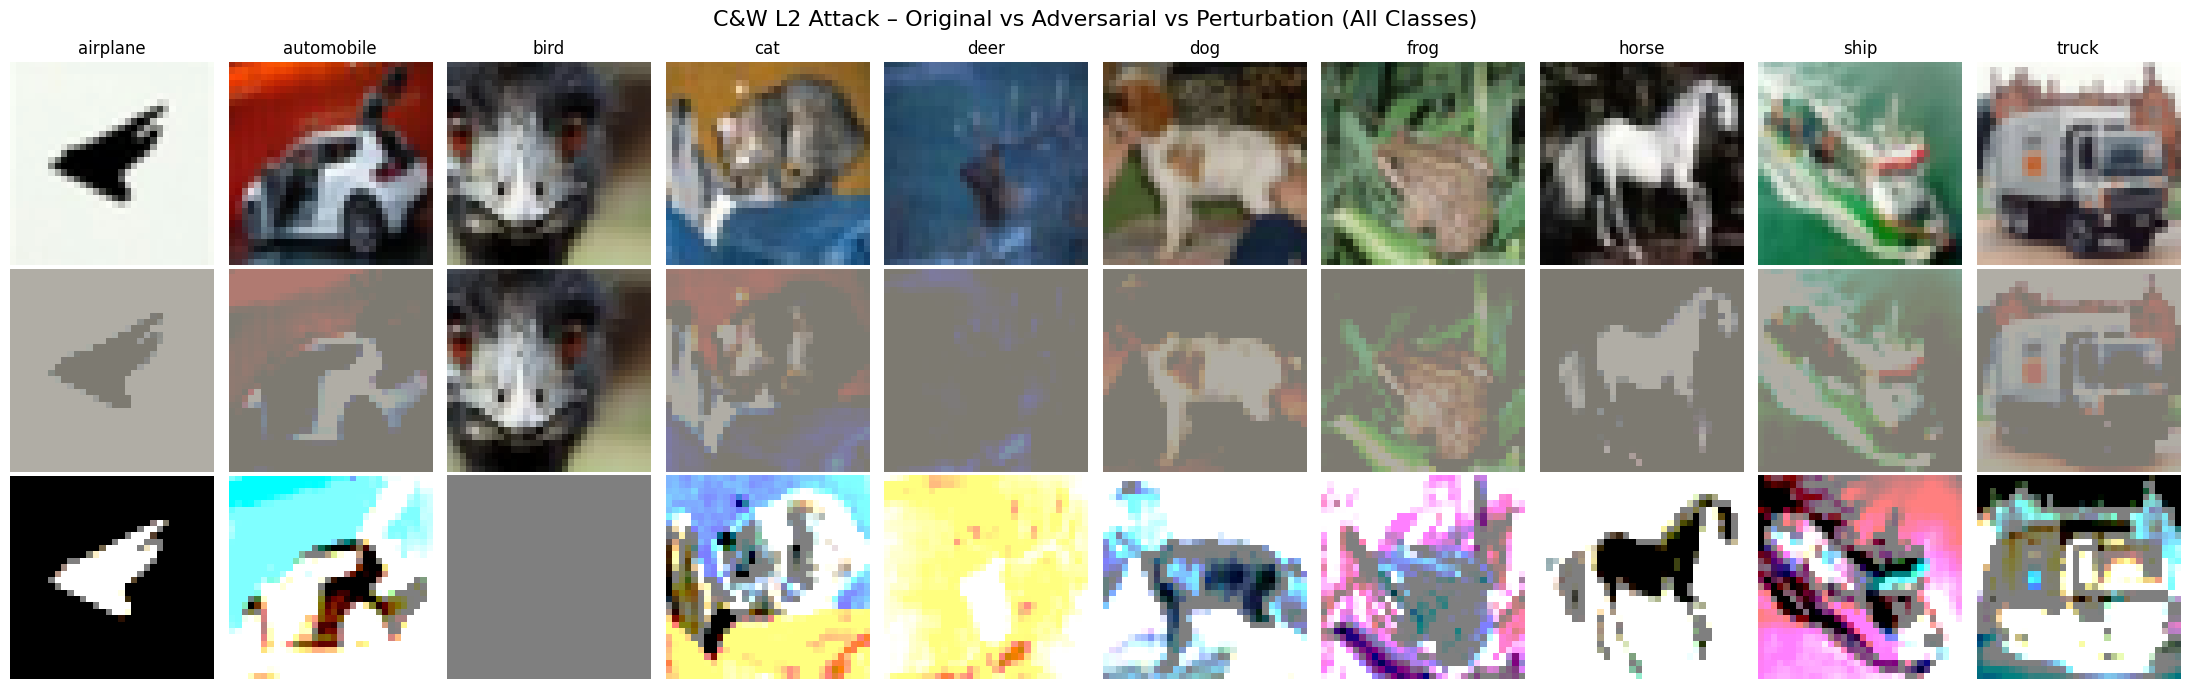

In [31]:
# @title Visualization Grid for C&W Adversarial Examples (All Classes)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# helper to load image and convert to numpy
def load_img(path):
    return np.array(Image.open(path))

fig, axes = plt.subplots(3, 10, figsize=(22, 7))
fig.suptitle("C&W L2 Attack – Original vs Adversarial vs Perturbation (All Classes)", fontsize=16)

for cls in range(10):
    orig = load_img(f"cw_adv_examples_per_class/{cls}_orig.png")
    adv = load_img(f"cw_adv_examples_per_class/{cls}_adv.png")
    pert = load_img(f"cw_adv_examples_per_class/{cls}_pert.png")

    # Row 1 – Original
    axes[0, cls].imshow(orig)
    axes[0, cls].set_title(f"{cifar10_classes[cls]}")
    axes[0, cls].axis('off')

    # Row 2 – Adversarial
    axes[1, cls].imshow(adv)
    axes[1, cls].axis('off')

    # Row 3 – Perturbation (scaled)
    axes[2, cls].imshow(pert)
    axes[2, cls].axis('off')

axes[0,0].set_ylabel("Original", fontsize=12)
axes[1,0].set_ylabel("Adversarial", fontsize=12)
axes[2,0].set_ylabel("Perturbation", fontsize=12)

plt.tight_layout()
plt.show()


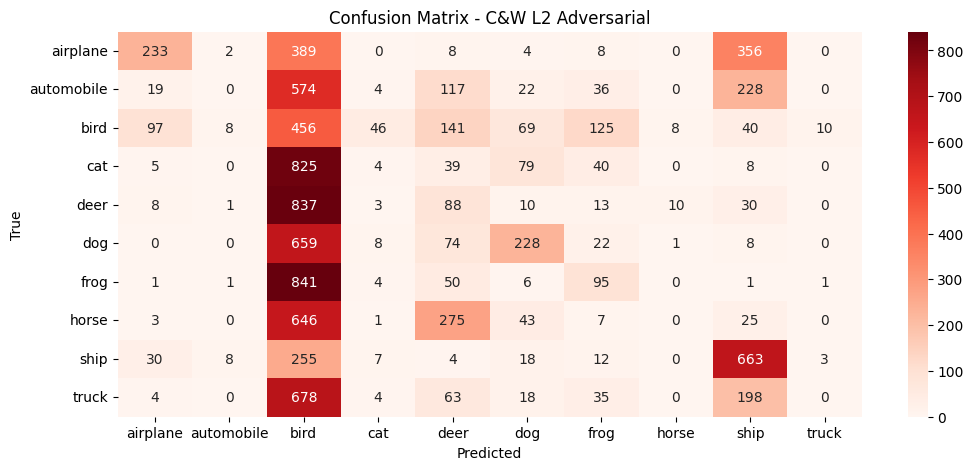

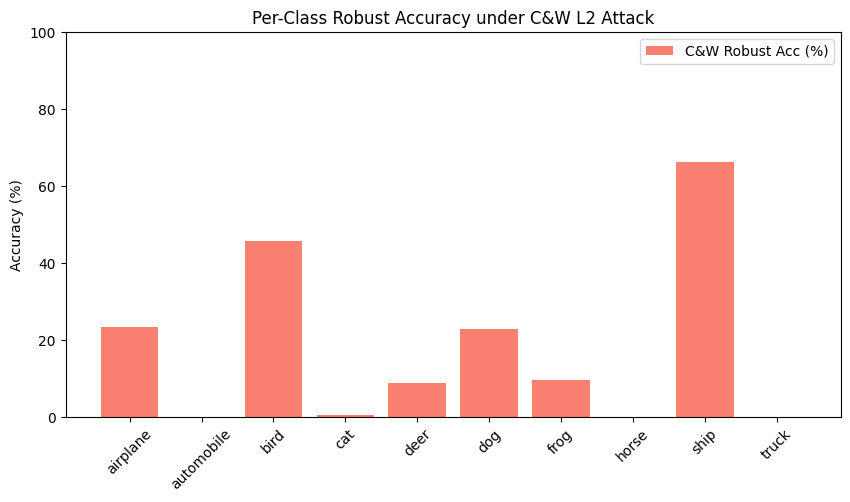

In [32]:
# @title C&W L2 Confusion Matrix & Per-Class Accuracy Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Heatmap
plt.figure(figsize=(12,5))
sns.heatmap(cm_cw, annot=True, fmt='d', cmap='Reds', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title('Confusion Matrix - C&W L2 Adversarial')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Bar chart for per-class C&W robust accuracy
plt.figure(figsize=(10,5))
x = np.arange(len(cifar10_classes))
plt.bar(x, df_cw['robust_acc_CW'], color='salmon', label='C&W Robust Acc (%)')
plt.xticks(x, cifar10_classes, rotation=45)
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Robust Accuracy under C&W L2 Attack')
plt.ylim(0, 100)
plt.legend()
plt.show()


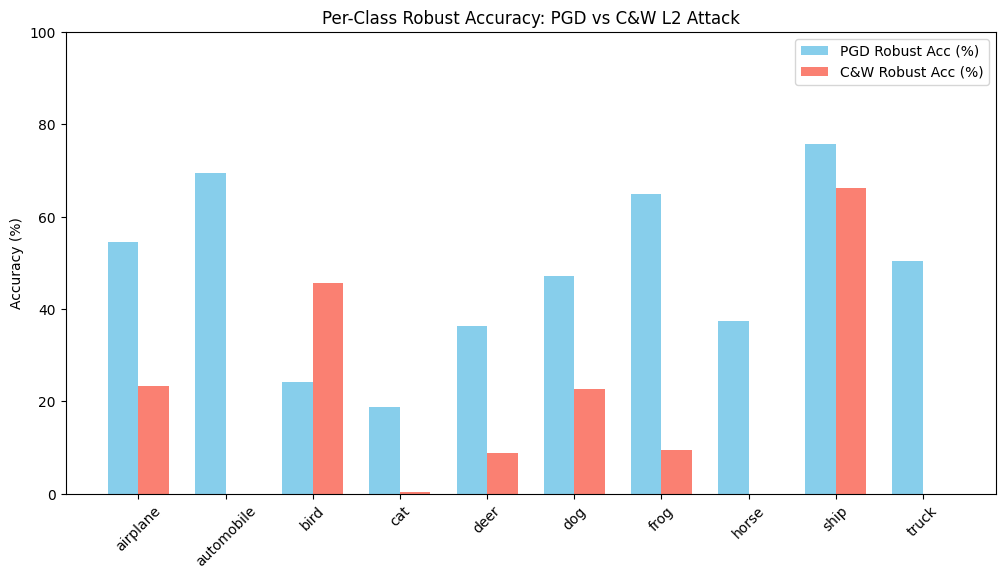

In [33]:
# @title Compare PGD vs C&W per-class robust accuracy
plt.figure(figsize=(12,6))

x = np.arange(len(cifar10_classes))
width = 0.35

plt.bar(x - width/2, df['robust_acc'], width, label='PGD Robust Acc (%)', color='skyblue')
plt.bar(x + width/2, df_cw['robust_acc_CW'], width, label='C&W Robust Acc (%)', color='salmon')

plt.xticks(x, cifar10_classes, rotation=45)
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Robust Accuracy: PGD vs C&W L2 Attack')
plt.ylim(0, 100)
plt.legend()
plt.show()
